# Volumetric Quantifications

This notebook demonstrates volumetric quantifications. It assumes you have properly [setup](./README.md) your environment and ran the introductory examples. Here's what we will accomplish:

1. Generate a convex hull of the axon terminals within a specific brain region
2. Compare the volume of this convex hull to the volume of the encompasing Allen CCF compartment.
3. Do PCA on the point cloud of the relevant axon terminals.
4. Visualize the results of these operations using [Reconstruction Viewer](https://imagej.net/SNT:_Reconstruction_Viewer).

## Imports
We'll need to 1) import Python modules; 2) initalize ij from local Fiji installation, and 3) import all relevant SNT (Java) classes: [AllenCompartment](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/annotation/AllenCompartment.html), [AllenUtils](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/annotation/AllenUtils.html), [Annotation3D](https://javadoc.scijava.org/SNT/sc/fiji/snt/viewer/Annotation3D.html), [ConvexHull2D](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/analysis/ConvexHull2D.html), [ConvexHull3D](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/analysis/ConvexHull3D.html), [MouseLightLoader](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/io/MouseLightLoader.html), [PointInImage](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/util/PointInImage.html), [Tree](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/Tree.html), [TreeAnalyzer](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/analysis/TreeAnalyzer.html), [Viewer3D](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/viewer/Viewer3D.html):

In [1]:
import os
import sys
import ijfinder
import imagej
import numpy as np
from collections import defaultdict

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

ij.ui().showUI()

from scyjava import jimport
AllenCompartment = jimport('sc.fiji.snt.annotation.AllenCompartment')
AllenUtils = jimport('sc.fiji.snt.annotation.AllenUtils')
Annotation3D = jimport('sc.fiji.snt.viewer.Annotation3D')
ConvexHull2D = jimport('sc.fiji.snt.analysis.ConvexHull2D')
ConvexHull3D = jimport('sc.fiji.snt.analysis.ConvexHull3D')
MouseLightLoader = jimport('sc.fiji.snt.io.MouseLightLoader')
NodeStatistics = jimport('sc.fiji.snt.analysis.NodeStatistics')
PointInImage = jimport('sc.fiji.snt.util.PointInImage')
Tree = jimport('sc.fiji.snt.Tree')
TreeAnalyzer = jimport('sc.fiji.snt.analysis.TreeAnalyzer')
Viewer2D = jimport('sc.fiji.snt.viewer.Viewer2D')
Viewer3D = jimport('sc.fiji.snt.viewer.Viewer3D')

We'll define two support functions: one to download the axonal arbor of a MouseLight neuron, the other to detect the brain area that is the most innervated by its axon:

In [2]:
def get_axon(id_string):
    """Fetchs an axonal arbor from the MouseLight database by ID"""
    loader = MouseLightLoader(id_string)
    if not loader.isDatabaseAvailable():
        print("Could not connect to ML database", "Error")
        return null
    if not loader.idExists():
        print("Somewhow the specified id was not found", "Error")
        return null
    # Extract the axon sub-tree
    return loader.getTree("axon")


def get_compartment_terminals(tree):
    """Finds the AllenCompartment containing the largest number 
    of axon terminal nodes and returns a collection containing 
    these nodes as well as the id of the relevant AllenCompartment"""
    
    # Use TreeAnalyzer to extract the terminal nodes from the Tree.
    # Instantiate a NodeStatistics instance and retrieve a list of the endpoints for
    # each target brain region (a BrainAnnotation) in a dictionary, where the keys are
    # the brain annotations. Since this neuron was fetched from the MouseLight database,
    # the annotations are instances of the AllenCompartment Class
    # https://morphonets.github.io/SNT/sc/fiji/snt/annotation/BrainAnnotation.html
    tips = TreeAnalyzer(tree).getTips()
    node_stats = NodeStatistics(tips)
    compartment_dict = node_stats.getAnnotatedNodes()

    # Get the compartment containing the maximum number of axon terminals
    max_compartment = max(compartment_dict, key= lambda x: len(compartment_dict[x]))
    # Get the associated list of terminals.
    compartment_tips = compartment_dict[max_compartment]
    
    return compartment_tips, max_compartment

In [3]:
# Load the reconstruction from the MouseLight database, fetching just the axon
tree_axon = get_axon('AA1044')
print(tree_axon.getLabel(), ":", len(TreeAnalyzer(tree_axon).getTips()), "terminals")

AA1044 (axon) : 2736 terminals


In [4]:
# Get the compartment with the maximum number of axon terminals
axon_terminals, compartment = get_compartment_terminals(tree_axon)
print(str(len(axon_terminals)) + " terminals in " + str(compartment.name()))

2734 terminals in Caudoputamen


In [5]:
# We can get the dominant hemi-half of the target compartment using AllenUtils
axon_terminals_coords = [[t.getX(), t.getY(), t.getZ()] for t in axon_terminals]
centroid = np.mean(axon_terminals_coords, axis=0)
hemisphere = "left" if AllenUtils.isLeftHemisphere(centroid[0], centroid[1], centroid[2]) else "right"
print(f"Dominant hemisphere of {compartment.name()}: " + hemisphere)

Dominant hemisphere of Caudoputamen: right


2D Convex hull area: 690300.9010607228
2D Convex hull perimeter: 3116.5437770608128


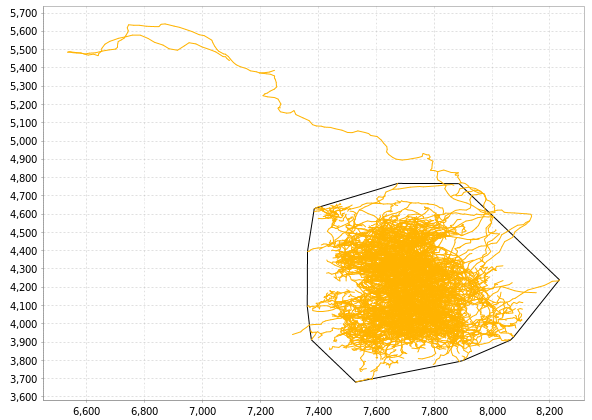

In [6]:
# Now compute the convex hulls
# If we compute a 2D convex hull over a 3D Tree, z coordinates are ignored
axon_hull_2D = ConvexHull2D(axon_terminals, True) # compute size
# We have to call compute() to generate the hull
axon_hull_2D.compute()
# size corresponds to volume in 3D, area in 2D
# boundarySize corresponds to area in 3D, perimeter in 2D
print("2D Convex hull area: " + str(axon_hull_2D.size()))
print("2D Convex hull perimeter: " + str(axon_hull_2D.boundarySize()))
viewer2d = Viewer2D(ij.getContext())
viewer2d.add(tree_axon)
viewer2d.addPolygon(axon_hull_2D.getPolygon(), "Convex Hull 2D Projection")
viewer2d.show()

# from IPython.display import Image, display
# display(Image(filename=r"./images/convexhull2D.png",  width=500))

In [7]:
axon_hull_3D = ConvexHull3D(axon_terminals, True) # compute size
axon_hull_3D.compute()
print("3D Convex hull volume: " + str(axon_hull_3D.size()))
print("3D Convex hull area: " + str(axon_hull_3D.boundarySize()))

3D Convex hull volume: 535293148.7685002
3D Convex hull area: 3674101.9762275284


In [8]:
# Get the OBJMesh which represents the AllenCompartment instance.
# Most meshes have pre-computed volumes (via surface integrals) associated with them.
# However, certain meshes (e.g., third ventricle) are not watertight,
# which precludes a direct volume calculation. 
# Still, it is possible to approximate the volume of these compartments
# using the convex hull computed by Viewer3D.
# https://morphonets.github.io/SNT/sc/fiji/snt/viewer/OBJMesh.html
obj_mesh = compartment.getMesh()

# Now compare the volumes of the 3D convex hull and the compartment mesh
# Since this compartment mesh is composed of both hemi-halves, we can approximate
# the volume of one hemi-half by dividing the total mesh volume by 2 (assuming perfect symmetry).
print("Percentage of volume occupied by the convex hull of "
      "the axon terminals with respect to the {} {} {:0.2f}%"
      .format(hemisphere, compartment, (axon_hull_3D.size() / (0.5 * obj_mesh.getVolume())) * 100)
)

Percentage of volume occupied by the convex hull of the axon terminals with respect to the right Caudoputamen [CP] 4.13%


In [9]:
# Now we may begin adding the computed objects to SNT's Viewer3D.
# Viewer3D has a script-friendly 'add' method which accepts a variety of differnent objects,
# e.g., Tree, AbstractDrawable, OBJMesh, etc...
viewer = Viewer3D(ij.getContext())
viewer.add(tree_axon)

# Add the compartment mesh, which contains both left and right nuclei.
viewer.add(obj_mesh)

# Construct a drawable for Viewer3D from the ImageJ Mesh
# https://javadoc.scijava.org/ImageJ/net/imagej/mesh/Mesh.html
annotation = Annotation3D(
    axon_hull_3D.getMesh(),
    f"Convex hull of axom terminals within {hemisphere} {compartment.name()}"
)
annotation.setColor("orange", 95) # transparency (%)
viewer.add(annotation)

In [10]:
# Finally, we can visualize all our hard work!
viewer.show()
viewer.setAnimationEnabled(True)

# To embed a snapshot in this notebook
# snapshot_path = os.getcwd() + '/images/convexhull.png'
# viewer.saveSnapshot(snapshot_path)
# from IPython.display import Image, display
# display(Image(filename=snapshot_path))

![](./images/convexhull.png)

As a bonus, let's estimate the principal components of the covariance on the point cloud given by the axon terminals and annotate the resulting eigenvectors as line segments.

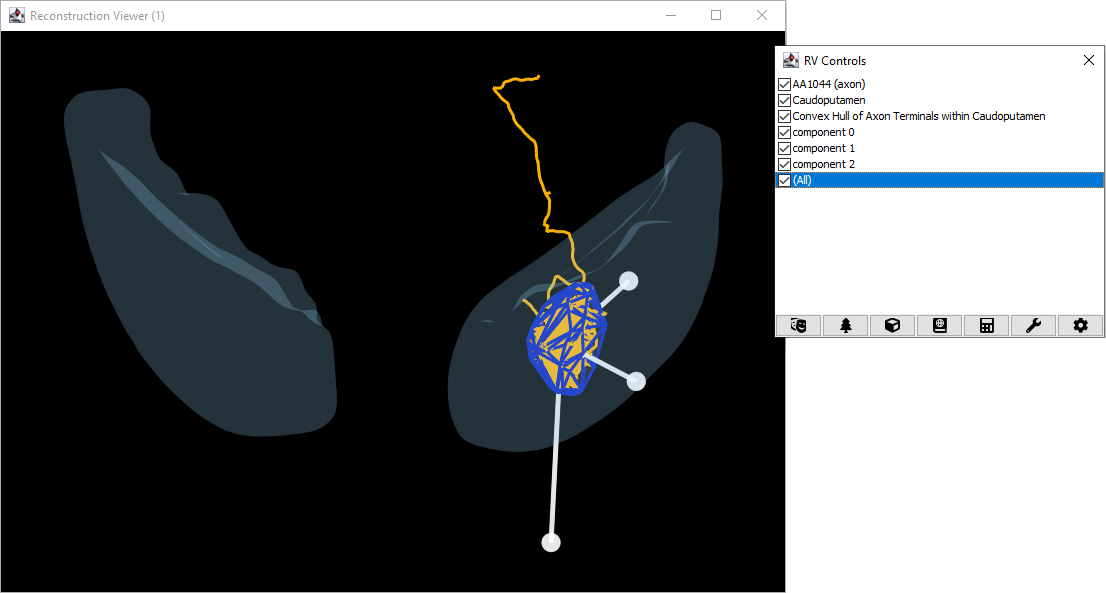

In [11]:
# First, subtract the mean from the points.
points = np.copy(axon_terminals_coords)
points -= centroid
# Compute the eigenvalues and eigenvectors of the covariance matrix.
e_values, e_vectors = np.linalg.eig(np.cov(points.transpose()))

# Construct the line segments using the eigenvectors.
viewer.setAnimationEnabled(False)
viewer.setSceneUpdatesEnabled(False)
for i in range(e_vectors.shape[1]):
    # The line segments will originate at the centroid of the terminals.
    end = centroid + ((np.sqrt(e_values[i]) * 10) * e_vectors[:, i])
    line_segment = [PointInImage(centroid[0], centroid[1], centroid[2]), PointInImage(end[0], end[1], end[2])]
    # Viewer3D supports adding annotations of various types, and allows customization of 
    # their visual properties.
    # https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Annotation3D.html
    annot = viewer.annotateLine(line_segment, "component {}".format(i))
    annot.setColor("white", 10)
    annot.setSize(20)

viewer.setSceneUpdatesEnabled(True)
viewer.updateView()

# from IPython.display import Image, display
# display(Image(filename=r"./images/convexhull-PCA.png",  width=1000))